## Transfer Learning DenseNet121 using Keras

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import the libraries as shown below
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as ss
from imutils import paths
import numpy as np
from glob import glob
import os
import cv2

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [256, 256]
train_path = '/content/gdrive/MyDrive/data/train'
valid_path = '/content/gdrive/MyDrive/data/test'

In [ ]:
def imgm(img,size=(256,256)):
    img=cv2.resize(img,size)
    img=img/255
    return img

In [ ]:
# Here we will be using imagenet weights
densnet121 = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in densnet121.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/gdrive/MyDrive/data/train/*')
x = Flatten()(densnet121.output)
x = keras.layers.Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=densnet121.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/data/train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1600 images belonging to 5 classes.


In [16]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/data/test',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 400 images belonging to 5 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint
model_path = '/content/gdrive/MyDrive/256densnet121.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
r = model.fit_generator(training_set, validation_data=test_set, epochs=50,
                        steps_per_epoch=2, validation_steps=2, callbacks=callbacks_list)

<ipython-input-32-694d471fb43b>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(
Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9531
Epoch 1: val_accuracy improved from 0.98438 to 1.00000, saving model to /content/gdrive/MyDrive/256densnet121.h5
2/2 [==============================] - 29s 26s/step - loss: 0.1415 - accuracy: 0.9531 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9531
Epoch 2: val_accuracy did not improve from 1.00000
2/2 [==============================] - 29s 25s/step - loss: 0.1768 - accuracy: 0.9531 - val_loss: 0.3144 - val_accuracy: 0.9375
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9688
Epoch 3: val_accuracy did not improve from 1.00000
2/2 [==============================] - 25s 20s/ste

In [34]:
y_pred = model.predict(test_set)

13/13 [==============================] - 50s 4s/step


In [35]:
path=list(paths.list_images("/content/gdrive/MyDrive/data/test"))
IMG=[]
label=[]

for (i, image_path) in enumerate(path):
    image = cv2.imread(image_path)
    lab = image_path.split(os.path.sep)[-2].split(".")[0]
    # extract raw pixel intensity "features
    pixels = imgm(image)
    IMG.append(pixels)
    label.append(lab)

x = np.array(IMG)
y = np.array(label)

In [36]:
Y=[]
for a,b in enumerate(y):
  if b=="corrugation":
    Y.append(0)
  if b=="flaking":
    Y.append(1)
  if b=="non-defective":
    Y.append(2)
  if b=="shelling":
    Y.append(3)
  if b=="squats":
    Y.append(4)

In [37]:
x

array([[[[0.52156863, 0.65882353, 0.75686275],
         [0.53333333, 0.66666667, 0.78039216],
         [0.56078431, 0.68235294, 0.80392157],
         ...,
         [0.68627451, 0.83921569, 1.        ],
         [0.68235294, 0.82745098, 1.        ],
         [0.68235294, 0.82745098, 1.        ]],

        [[0.56470588, 0.69411765, 0.79607843],
         [0.57254902, 0.69411765, 0.81568627],
         [0.59607843, 0.70980392, 0.83137255],
         ...,
         [0.69803922, 0.83921569, 0.99607843],
         [0.68235294, 0.82745098, 1.        ],
         [0.68235294, 0.82745098, 1.        ]],

        [[0.60784314, 0.72156863, 0.84313725],
         [0.61568627, 0.72941176, 0.85098039],
         [0.62352941, 0.7372549 , 0.85882353],
         ...,
         [0.69411765, 0.83137255, 1.        ],
         [0.69019608, 0.82745098, 1.        ],
         [0.68235294, 0.82745098, 1.        ]],

        ...,

        [[0.05490196, 0.07843137, 0.19215686],
         [0.05490196, 0.08235294, 0.15686275]

In [38]:
y_pred = model.predict(x)

13/13 [==============================] - 2s 139ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0,
       0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
y_test=Y
target_names = ['non-defective', 'corrugation', 'flaking', 'shelling', 'squats']
print(classification_report(y_test, y_pred, target_names=target_names))  

Classification Report (DenseNet121)

Class           Precision    Recall  F1-Score   Support
Corrugation          1.00      1.00      1.00        80
Flaking              0.78      0.96      0.86        80
Non-defective        0.96      0.85      0.90        80
Shelling             1.00      0.89      0.94        80
Squats               1.00      0.99      0.99        80

Accuracy                                 0.92       400
Macro avg            0.92      0.92      0.92       400
Weighted avg         0.92      0.92      0.92       400


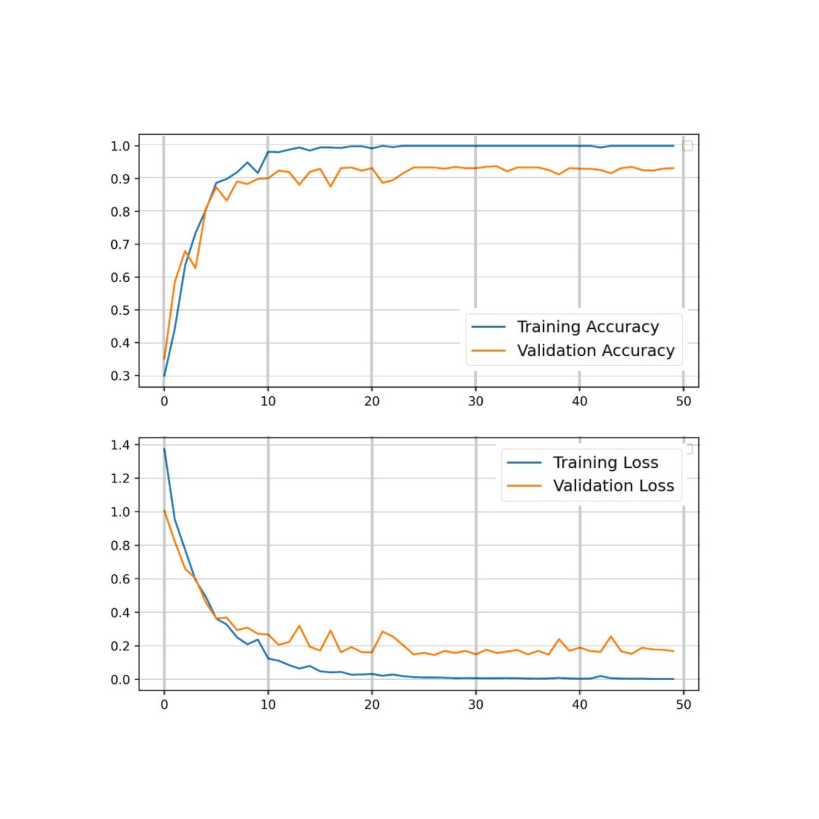

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# Plot accuracy
ax1.plot(r.history['accuracy'], label='Training Accuracy')
ax1.plot(r.history['val_accuracy'], label='Validation Accuracy')
ax1.legend()
ax1.grid(True)
# Plot loss
ax2.plot(r.history['loss'], label='Training Loss')
ax2.plot(r.history['val_loss'], label='Validation Loss')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig('Training_Validation_Metrics.png')
plt.show()